# An (incomplete) tour of uproot, data analysis and particle physics

We will use some state-of-the-art python packages and tools. Be sure that you followed the setup instructions listed [here](https://github.com/danbarto/tW_scattering/blob/master/README.md) and have jupyter running on your computer.

What we will cover:
- Loading root files with uproot
- Accessing the stored data
- Physics objects
- Selecting objects and events
- Make histograms and plots

First, we load the necessary packages:
- [uproot](https://github.com/scikit-hep/uproot) for reading root files (we are currently using uproot, while [uproot4](https://github.com/scikit-hep/uproot4) will be the default in the future)
- Some functions from [uproot_methods](https://github.com/scikit-hep/uproot-methods) and [coffea](https://github.com/CoffeaTeam/coffea)
- [numpy](https://numpy.org) which is *the* package for scientific computing with Python, see the new [numpy paper](https://www.nature.com/articles/s41586-020-2649-2) for more details


## Interlude: Difference between event loop and columnar analysis

Our data samples (both the ones recorded from the detector and simulated ones) are organized in terms of events.
So in order to analyze the data we traditionally looped over the events in order to calculate new variables, fill histograms etc.
The alternative approach is to do a columnar analysis instead of the event loop.
This removes the need for a lot of the explicit (and often nested) loops, makes better use of modern CPUs and should make the analysis code more intuitive to write and read.
Hopefully, that's what we are going to learn in this tutorial.

[Reference](https://indico.cern.ch/event/845905/contributions/3573852/attachments/1914906/3165453/ahall_CoffeaUpdate_CMSWeek_Sep2019.pdf)


In [1]:
import uproot
import numpy as np
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray


Now we load a root file of a simulated sample of proton-proton collisions. The file path reveals some details of the type of process that's contained:

TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1

- TTZ: production of a top quark/antiquark pair in association with a Z boson. This is a rather complicated process, but contains a lot of interesting physics.
- ToLLNuNu: means that only events where the Z boson decays to two charged or neutral leptons (electrons, muons, taus, or neutrinos) are simulated
- M-10: the invariant mass of the Z boson has to be larger than 10 GeV
- The rest are more technical details. We can look at those later


In [2]:
fn = '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/0p1p9/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1/nanoSkim_1.root'
file = uproot.open(fn)

The root file contains several [ROOT trees]() which we can see by running `file.keys()`. We are only interested in the *Events* tree and will load it.

In [3]:
print (file.keys())
tree = file['Events']

[b'Events;1', b'Runs;1', b'LuminosityBlocks;1', b'untagged;1']


The tree contains all the information about the proton-proton collision events. We can look at the information by running `tree.show()`.

In [4]:
tree.show()

run                        (no streamer)              asdtype('>u4')
luminosityBlock            (no streamer)              asdtype('>u4')
event                      (no streamer)              asdtype('>u8')
nElectron                  (no streamer)              asdtype('>u4')
Electron_deltaEtaSC        (no streamer)              asjagged(asdtype('>f4'))
Electron_dxy               (no streamer)              asjagged(asdtype('>f4'))
Electron_dz                (no streamer)              asjagged(asdtype('>f4'))
Electron_eCorr             (no streamer)              asjagged(asdtype('>f4'))
Electron_eInvMinusPInv     (no streamer)              asjagged(asdtype('>f4'))
Electron_energyErr         (no streamer)              asjagged(asdtype('>f4'))
Electron_eta               (no streamer)              asjagged(asdtype('>f4'))
Electron_hoe               (no streamer)              asjagged(asdtype('>f4'))
Electron_ip3d              (no streamer)              asjagged(asdtype('>f4'))
Electron_jetP

We can access the data by converting the branches into a numpy-like array. It's only numpy-like, because the dimension isn't fixed, so e.g. there can be a different number of Muons in each event. We called the array type *JaggedArray*.
As an example let's look at `tree.array("Muon_pt")`. You'll notice that it takes some time to load, so we can use a *lazy* version `tree.lazyarray("Muon_pt")` which only loads parts of the data.

In [5]:
tree.array("Muon_pt")

<JaggedArray [[77.87576 13.909524] [39.76917] [115.22565] ... [73.975075 53.133705] [28.121792 21.50151 21.318266 4.0434313 3.9680626] []] at 0x7fcd191fd0b8>

In [6]:
tree.lazyarray("Muon_pt")

<ChunkedArray [[77.87576 13.909524] [39.76917] [115.22565] ... [73.975075 53.133705] [28.121792 21.50151 21.318266 4.0434313 3.9680626] []] at 0x7fcd97506cc0>

For a more detailed tutorial on uproot and it's interface to root trees you can check out the tutorial [here](https://github.com/scikit-hep/uproot/blob/master/binder/tutorial.ipynb).

Instead of looking at all the arrays individually we can convert the tree into a DataFrame, and we will again use the *lazy* version. Then, we can use coffea methods like *JaggedCandidateArray* to create objects that are resembling phyiscs objects, like jets, electrons, muons, taus or photons.

Our two examples will be jets and muons.
A *JaggedCandidateArray* will create a four-vector and therefora needs (as minimum) the transverse momentum pt, pseudorapidity eta, azimuthal angle phi and mass, as well as the total number of the object in each event. We can also load additional information, like a discriminator called *btagDeepB* for b-jets vs light quark flavor jets.

Once we have the jets and muons, we can look at their properties with e.g. `jets.pt` or `muons.eta` which will return a JaggedArray.

In [7]:
df = LazyDataFrame(tree, flatten=True)

jets = JaggedCandidateArray.candidatesfromcounts(
    df['nJet'],
    pt=df['Jet_pt'],
    eta=df['Jet_eta'],
    phi=df['Jet_phi'],
    mass=df['Jet_mass'],
    btagDeepB=df['Jet_btagDeepB'],
    jetId=df['Jet_jetId'],
)
muons = JaggedCandidateArray.candidatesfromcounts(
    df['nMuon'],
    pt=df['Muon_pt'],
    eta=df['Muon_eta'],
    phi=df['Muon_phi'],
    mass=df['Muon_mass'],
    mediumId=df['Muon_mediumId'],
    miniPFRelIso_all=df['Muon_miniPFRelIso_all'],
    charge=df['Muon_charge'],
)

We can now filter these objects and e.g. only look at jets with pt>30 GeV and absolute eta less than 2.4. Let's check if that really worked by looking at `selected_jets.pt` and `selected_jets.eta`.

In [8]:
selected_jets = jets[((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetId>0))]
selected_jets.pt

<JaggedArray [[121.0 89.375 74.0 48.5] [232.25 191.875 134.375 ... 94.5 47.6875 47.09375] [135.375 43.25 35.65625] ... [165.0 90.4375 80.6875 ... 42.71875 37.21875 33.125] [61.03125 52.625 47.3125 41.09375 36.125] [160.125 137.125 48.40625 44.0]] at 0x7fcd1922f7f0>

## Interlude: Plotting

We can use matplotlib for plotting different types of histograms. This is also useful to check whether one of the filters (or selections, as we usually call it in HEP) is really working as we intended.
Let's first look at the pt distribution of all the unfiltered `jets` and the filtered `selected_jets`.


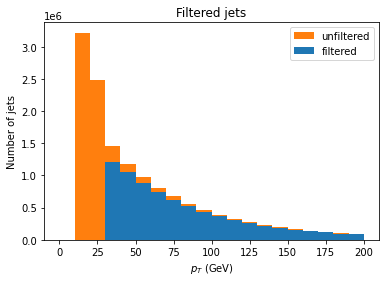

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

figure=plt.figure(1)
plt.hist([selected_jets.pt.flatten(), jets.pt.flatten()], bins=20, range=[0, 200], label=['filtered', 'unfiltered'], histtype='stepfilled', alpha=1.0)
plt.xlabel(r'$p_{T}$ (GeV)')
plt.ylabel('Number of jets')
plt.title('Filtered jets')
plt.legend()

plt.show()


Ok, this seems fine! You probably noticed that we don't use `jets.pt` to fill the histogram, but add `flatten()`. This has a rather simple reason: the histogram can't handle JaggendArrays, and we have to provide a flat array instead.

Let us also look at a 2D histogram to see if both the eta and pt requirements worked. Notice that we use the `cmin=1` option in order to not color bins of the histogram that have a count of zero.

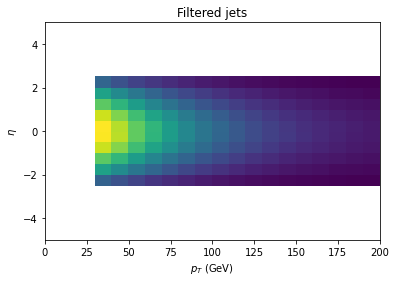

In [10]:
figure=plt.figure(1)
plt.hist2d(selected_jets.pt.flatten(), selected_jets.eta.flatten(), bins=20, range=[[0, 200], [-5,5]], cmin = 1)
plt.xlabel(r'$p_{T}$ (GeV)')
plt.ylabel(r'$\eta$')
plt.title('Filtered jets')

plt.show()

As expected, we don't have any selected jets outside the required eta and pt range.

Now let's implement a rather realistic selection of jets and muons.
There can be some overlap between those two selections, so we will remove any jet object that is also a muon object. In order to do this we check if the seperation measured in $\Delta R = \sqrt{(\phi_1-\phi_2)^2+(\eta_1-\eta_2)^2}$ between the jets and muons is smaller than $\Delta R < 0.4$. In case it is, we remove ("clean") the jet, and only keep the muon.

We also define another category of jets which we call b-tagged, which are the jets that pass a certain threshold of the b-tagger.

In [11]:
good_muons = muons[((muons.pt>25) & (abs(muons.eta)<2.4) & (muons.mediumId==1) & (muons.miniPFRelIso_all<0.12))]

cleaned_jets = selected_jets[~selected_jets.match(good_muons, deltaRCut=0.4)]
btagged_jets = cleaned_jets[(cleaned_jets.btagDeepB>0.8484)]


So far we have only dealt with objects and define collections like `good_muons` or `cleaned_jets`. Now let's look at events.

We can get different final states in a ttZ event, mainly depending on the decays of the Z and W bosons, where the W boson comes from the $t \to b W$ decay. For our little exercise let's only use events where the Z boson decays into two muons. We can therefore require at least two muons (we can have additional ones from the W boson decays).

We also ask for at least one b-tagged jet (our b-tagger is only 60-70% efficient), and at least three jets.

In [12]:
event_selection = (good_muons.counts>=2) & (btagged_jets.counts>0) & (cleaned_jets.counts>2)

Now this is all nice, but the two muons can basically come from either the W bosons or the Z boson.

First, we get any pairing of two muons by using `choose(2)`, and then we require the muons to have opposite charge. Therefore, the product of the charges has to be smaller than 0, `dimuons.i0.charge * dimuons.i1.charge<0`. We often refer to leptons with opposite charge as opposite sign, or OS.

Second, we require the invariant mass of the two muons to be close to the Z boson mass, $|m(\mu\mu)-91.2| < 10~\textrm{GeV}$ ("on-Z")

In [13]:
dimuons = good_muons.choose(2)

OSmuons = dimuons[(dimuons.i0.charge * dimuons.i1.charge<0)]
onZ = ((abs(OSmuons.mass-91.2)<10).any())

event_selection = event_selection & onZ

Let's also calculate the transverse mass between the b-tagged jets and the missing transverse momentum. We have a predifined function in our helpers. For events with more than one b-tagged jets this will calculate all the possible transverse masses, and we could then look at the MET_pt itself after requiring that at least one of the MT values calculated per event is larger than 150 GeV

In [38]:
from Tools.helpers import mt

mt_met_b = mt(df['MET_pt'], df['MET_phi'], btagged_jets.pt, btagged_jets.phi)
df['MET_pt'][event_selection & ((mt_met_b>150).any())]

array([ 75.88225 , 153.22568 ,  51.275753, ..., 210.58563 , 187.94276 ,
       123.01743 ], dtype=float32)

If we're not sure if what we coded up is actually doing what we hoped it would be doing we can just look at the mt values itself, after requiring `(mt_met_b>150).any()`. It seems to have worked :)

In [40]:
mt_met_b[event_selection & ((mt_met_b>150).any())]

<JaggedArray [[185.61488] [258.84537] [171.5205] ... [175.06328 61.71579] [381.73288 99.4935] [229.08337 121.38798]] at 0x7fccfc8e72b0>

Now that we have defined an event_selection, we can plot any quantitiy for exactly those events. As an example, we can look at the minimum transverse mass we just calculated, or the jet pt of the jet with the highest/lowest eta.

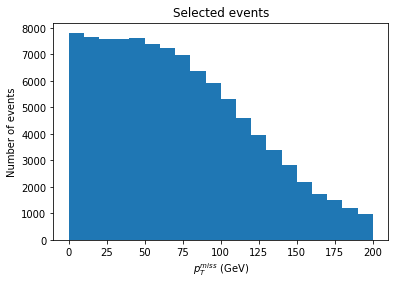

In [44]:
figure=plt.figure(1)
plt.hist([mt_met_b[event_selection].min()], bins=20, range=[0, 200], histtype='stepfilled', alpha=1.0)
plt.xlabel(r'$p_{T}^{miss}$ (GeV)')
plt.ylabel('Number of events')
plt.title('Selected events')

plt.show()

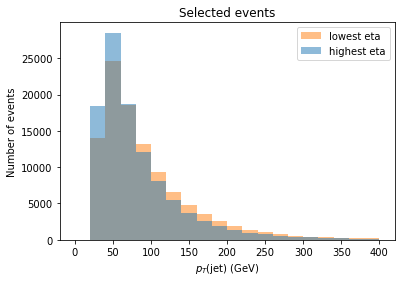

In [45]:

figure=plt.figure(1)
plt.hist([selected_jets[abs(selected_jets.eta).argmax()][event_selection].pt.flatten(), selected_jets[abs(selected_jets.eta).argmin()][event_selection].pt.flatten()], label=['highest eta', 'lowest eta'], bins=20, range=[0, 400], histtype='stepfilled', alpha=0.5)
plt.xlabel(r'$p_{T}$(jet) (GeV)')
plt.ylabel('Number of events')
plt.title('Selected events')
plt.legend()

plt.show()

As a short summary, we should have learned how to load a root file with uproot, look at its content, access the data, filter objects and events, and make histograms of quantities.

Especially the *JaggedArray* class has a lot of nice features, like the *choose*, *match*, or *pair* functions. We will use those on several occasions, but now let's jump into an example of processing a bit larger amounts of data than just one file.


## Getting closer to real life

Before we start, let's look at how many events we actually loaded and processed in the example before. We can use a standard `len()` command, like  


In [46]:
len(df['MET_pt'])

1391893

So we looked at 1.4 million events contained in one single root file. Not too bad, but also not as many as we usually do.

To process larger amounts of data we can use coffea *processors*. The idea behind them is that we split the data into several chunks and process them in parallel. This can happen on several threads on one server (what we will do in the following), or distributed (not covered here). The processed data is accumulated, and we can define what kind of data we want to retrieve from there. Typically, we want to select certain objects, calculate some variables like invariant masses, fill histograms and get the number of events that pass a certain selection.

The histograms and counts we want to store are defined on initialization of the processor. For our example, we will make histograms of MET, the invariant lepton mass, the number of jets, and some invariant masses that are discussed in the comments of the process function.

In [47]:
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist

from Tools.helpers import loadConfig, getCutFlowTable, mergeArray
from Tools.objects import Collections
from Tools.cutflow import Cutflow

import copy

class exampleProcessor(processor.ProcessorABC):
    """Dummy processor used to demonstrate the processor principle"""
    def __init__(self):

        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "ST" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mbj_max" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_ele" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_mu" :            hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_jet" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'diboson':          processor.defaultdict_accumulator(int),
            'ttbar':            processor.defaultdict_accumulator(int),
            'TTW':              processor.defaultdict_accumulator(int),
            'TTZ':              processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()

        # load all the default candidates (jets, leptons, ...)
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            jetId = df['Jet_jetId'].content,
            puId = df['Jet_puId'].content,
            btagDeepB = df['Jet_btagDeepB'].content,
            
        )
        jet       = jet[(jet.pt>30) & (abs(jet.eta)<2.4) & (jet.jetId>0)]
        
        ## Muons. We take a short-cut by using a class that loads the muon collection
        muon = Collections(df, "Muon", "tight").get()
        vetomuon = Collections(df, "Muon", "veto").get()
        dimuon = muon.choose(2)
        OSmuon = ( dimuon[(dimuon.i0.charge * dimuon.i1.charge)<0].counts>0 )
        
        
        ## Electrons. We take a short-cut by using a class that loads the electron collection
        electron = Collections(df, "Electron", "tight").get()
        vetoelectron = Collections(df, "Electron", "veto").get()
        dielectron = electron.choose(2)
        OSelectron = ( dielectron[(dielectron.i0.charge * dielectron.i1.charge)<0].counts>0 )

        # Remove jet/lepton overlap, and define b-tagged and light jets afterwards
        jet       = jet[~jet.match(muon, deltaRCut=0.4)]
        jet       = jet[~jet.match(electron, deltaRCut=0.4)]
        btag      = jet[(jet.btagDeepB>0.8484)]
        light     = jet[(jet.btagDeepB<0.8484)]        
        
        ## E/Mu pair - not used here
        dilepton = electron.cross(muon)

        ## MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]

        ## Event classifieres
        st = df["MET_pt"] + jet.pt.sum() + muon.pt.sum() + electron.pt.sum()
        ht = jet.pt.sum()
        
        # Pairs of b-tagged jets and other jets/leptons
        bj = btag.cross(jet) # Use jet instead of light to not run into problems when all jets are b-tagged.
        mub = muon.cross(btag)
        elb = electron.cross(btag)
        
        mub_mass_min = mub[mub.mass.argmax()].mass
        elb_mass_min = elb[elb.mass.argmax()].mass
        lb_mass_min = mergeArray(mub_mass_min,elb_mass_min).min()
        
        ## define selections 
        dilep      = ((electron.counts + muon.counts)==2)
        lepveto    = ((vetoelectron.counts + vetomuon.counts)==2)
        OS         = (OSelectron | OSmuon)
        onZ        = ((abs(dimuon.mass-91.2)<10).any() | (abs(dielectron.mass-91.2)<10).any() )


        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        processes = ['TTW', 'TTZ', 'diboson']
        cutflow = Cutflow(output, df, cfg, processes)
        
        cutflow.addRow( 'dilep',       dilep )
        cutflow.addRow( 'lepveto',     lepveto )
        cutflow.addRow( 'OS',          OS )
        cutflow.addRow( 'on-Z',        onZ )
        cutflow.addRow( 'njet2',       (jet.counts>=2) )
        cutflow.addRow( 'btag1',       (btag.counts>=1) )
        cutflow.addRow( 'met50',       (met_pt > 50) )


        # preselection of events
        dilep_onZ = ( dilep & lepveto & OS & onZ )
        event_selection = cutflow.selection
        
        ## And fill the histograms
        
        # just the number of electrons and muons
        output['N_ele'].fill(dataset=dataset, multiplicity=electron[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        output['N_mu'].fill(dataset=dataset, multiplicity=muon[event_selection].counts, weight=df['weight'][event_selection]*cfg['lumi'])
        
        # N jet and N b without selections on those
        output['N_jet'].fill(dataset=dataset, multiplicity=jet[dilep_onZ].counts, weight=df['weight'][dilep_onZ]*cfg['lumi'])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[dilep_onZ].counts, weight=df['weight'][dilep_onZ]*cfg['lumi'])
                
        output['MET_pt'].fill(dataset=dataset, pt=met_pt[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['ST'].fill(dataset=dataset, ht=st[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['HT'].fill(dataset=dataset, ht=ht[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['mbj_max'].fill(dataset=dataset, mass=bj[bj.mass.argmax()][event_selection].mass.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['mlb_min'].fill(dataset=dataset, mass=lb_mass_min[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        return output

    def postprocess(self, accumulator):
        return accumulator

Now that we have defined the processor, we need to define the list of files we want to process. There is a separate file [processor/samples.py](https://github.com/danbarto/tW_scattering/blob/master/processor/samples.py) that has some pre-defined file sets. Since this is just an example, we will only select a subset of the samples in the `fileset_2lOS` block. We will use 4 threads to process the data (we could use more, but we share resources with other people and have to be responsible). This will take a few minutes...

In [48]:
from processor.samples import fileset, fileset_small, fileset_2lOS

# Run the processor
fileset = fileset = {'TTW':fileset_2lOS['TTW'], 'TTZ':fileset_2lOS['TTZ'], 'diboson':fileset_2lOS['diboson']}
workers = 4
output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=exampleProcessor(),
                                      executor=processor.futures_executor,
                                      executor_args={'workers': workers, 'function_args': {'flatten': False}},
                                      chunksize=500000,
                                     )




/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(ufunc, method)(*inputs, **kwargs)


You can ignore the warnings (at least for now).

Let's check how many events we actually processed now. They are stored in the output dictinory: `output['totalEvents']`.

In [49]:
output['totalEvents']

defaultdict_accumulator(int, {'all': 24698627})

So we processed approximately 25M events with the processor, and we used 4 threads to process 70 chunks.

Let's take another look at the processor: We do run over samples for different processes now, and if we want to obtain meaningful numbers and histograms when we combine them, we need to normalize each event according to its physical cross section and the total number of simulated events. This is what's done in `weight=df['weight'][event_selection]*cfg['lumi']` when filling the histograms. `df['weight']` is a per-event weight. `cfg['lumi']` is a factor to normalize the prediction to 137/fb, the total integrated luminosity from the LHC Run2.

We also produce a cut-flow within the processor, and we can obtain the resulting table like this:

In [50]:
# Cutflow with absolute numbers
processes = ['TTW', 'TTZ', 'diboson']
lines = ['entry']
lines += ['dilep', 'lepveto', 'OS', 'on-Z', 'njet2', 'btag1', 'met50' ]
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='TTZ')
df

,TTW,TTZ,diboson,S/B
entry,27870.0 +/- 60.0,14820.0 +/- 10.0,1083000.0 +/- 1000.0,0.0133
dilep,3792.0 +/- 17.0,4260.0 +/- 7.0,159300.0 +/- 200.0,0.0261
lepveto,2849.0 +/- 15.0,2580.0 +/- 6.0,123700.0 +/- 100.0,0.0204
OS,957.0 +/- 10.0,2045.0 +/- 5.0,105000.0 +/- 100.0,0.0193
on-Z,118.1 +/- 3.6,1509.0 +/- 4.0,80230.0 +/- 80.0,0.0188
njet2,113.8 +/- 3.5,1489.0 +/- 4.0,60750.0 +/- 70.0,0.0245
btag1,71.12 +/- 2.78,893.5 +/- 3.4,3576.0 +/- 14.0,0.2450
met50,56.0 +/- 2.43,411.4 +/- 2.3,768.2 +/- 7.0,0.4992


In [55]:
# Cutflow with efficiencies for each cut
processes = ['TTW', 'TTZ', 'diboson']
lines = ['entry']
lines += ['dilep', 'lepveto', 'OS', 'on-Z', 'njet2', 'btag1', 'met50' ]
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False)
df

,TTW,TTZ,diboson
entry,1.0000,1.0000,1.0000
dilep,0.1361,0.2874,0.1471
lepveto,0.7514,0.6057,0.7767
OS,0.3359,0.7925,0.8486
on-Z,0.1235,0.7379,0.7641
njet2,0.9634,0.9866,0.7572
btag1,0.6248,0.6002,0.0589
met50,0.7874,0.4605,0.2149


So what this tells us is that after applying the $N_{b-tag}\geq1$ cut, we expect 893.5 ttZ events, 71.1 ttW events and 3576 diboson events. If ttZ is the process we are interested in (=signal) and the other processes are our background, this results in a signal-over-background ratio of ~0.2.

This is of course a simplified example, and we neglected the overwhelming contribution from the Drell-Yan and tt+jets processes. It's not an easy task to isolate ttZ events in an OS dilepton selection, as we have tried here :)

The second table shows the efficiency of each requirement w.r.t. the previous event selection. We use these tables to find optimal selections that have a high efficiency for the signal process, and a low efficiency for backgrounds.

Now let's try to obtain the histograms we have filled with the processor. If we just want to have a quick look at them, all we need to do is the following:

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


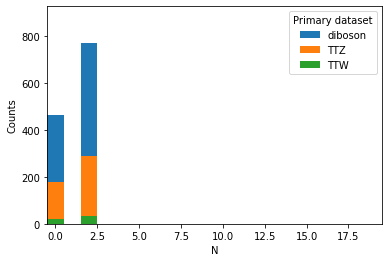

In [51]:
histogram = output['N_mu']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)

This gives us the number of muons per event, after applying our event selection. Of course we can also decorate the histograms, and rebin them. Let's look at the mlb_min histogram.

mlb_min is calculated in the processor as the minimum invariant mass of an electron or muon and a b-tagged jet. This variable is often used for roughly reconstructing leptonically decaying top quarks. Because we don't have top quarks in our diboson sample, and the top quarks of ttZ should decay hadronically (because of our selection), we don't see the expected endpoint around the top quark mass of ~175 GeV. Maybe we can see it for ttW? We can look at the shapes.

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:359: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:366: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_inter

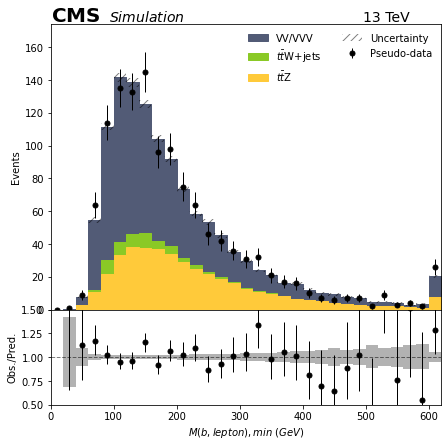

In [52]:
# load the config and the cache
cfg = loadConfig()

from plots.helpers import *
bins = {\
    'MET_pt':   {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$E_T^{miss} \ (GeV)$', 20, 0, 200)},
    'N_jet':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{jet}$', 15, -0.5, 14.5)},
    'N_ele':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{e}$', 3, -0.5, 2.5)},
    'N_mu':     {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{\mu}$', 3, -0.5, 2.5)},
    'N_b':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{b-jet}$', 5, -0.5, 4.5)},
    'mbj_max':  {'axis': 'mass',          'overflow':'over',  'bins': hist.Bin('mass', r'$M(b, light), max \ (GeV)$', 25, 0, 1500)},
    'mlb_min':  {'axis': 'mass',          'overflow':'over',  'bins': hist.Bin('mass', r'$M(b, lepton), min \ (GeV)$', 30, 0, 600)},
    'HT':       {'axis': 'ht',            'overflow':'over',  'bins': hist.Bin('ht', r'$H_{T} \ (GeV)$', 30, 0, 1500)},
    'ST':       {'axis': 'ht',            'overflow':'over',  'bins': hist.Bin('ht', r'$S_{T} \ (GeV)$', 30, 0, 1500)},
    }

plotDir = os.path.expandvars(cfg['meta']['plots']) + '/dump/'
finalizePlotDir(plotDir)

name = 'mlb_min'

if True:  
    histogram = output[name]

    axis = bins[name]['axis']
    histogram = histogram.rebin(axis, bins[name]['bins'])

    y_max = histogram.sum("dataset").values(overflow='over')[()].max()
    y_over = histogram.sum("dataset").values(overflow='over')[()][-1]

    # get pseudo data
    bin_values = histogram.axis(axis).centers(overflow=bins[name]['overflow'])
    poisson_means = histogram.sum('dataset').values(overflow=bins[name]['overflow'])[()]
    values = np.repeat(bin_values, np.random.poisson(np.maximum(np.zeros(len(poisson_means)), poisson_means)))
    if axis == 'pt':
        histogram.fill(dataset='pseudodata', pt=values)
    elif axis == 'eta':
        histogram.fill(dataset='pseudodata', eta=values)
    elif axis == 'mass':
        histogram.fill(dataset='pseudodata', mass=values)
    elif axis == 'multiplicity':
        histogram.fill(dataset='pseudodata', multiplicity=values)
    elif axis == 'ht':
        histogram.fill(dataset='pseudodata', ht=values)
    elif axis == 'norm':
        histogram.fill(dataset='pseudodata', norm=values)

    
    import re
    notdata = re.compile('(?!pseudodata)')

    fig, (ax, rax) = plt.subplots(2, 1, figsize=(7,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)

    # get axes
    hist.plot1d(histogram[notdata],overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=['TTZ', 'TTW','diboson']) #error_opts??
    hist.plot1d(histogram['pseudodata'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], error_opts=data_err_opts, clear=False)

    # build ratio
    hist.plotratio(
        num=histogram['pseudodata'].sum("dataset"),
        denom=histogram[notdata].sum("dataset"),
        ax=rax,
        error_opts=data_err_opts,
        denom_fill_opts={},
        guide_opts={},
        unc='num',
        overflow=bins[name]['overflow']
    )


    for l in ['linear']:
        saveFig(fig, ax, rax, plotDir, name, scale=l, shape=False, y_max=y_max)

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


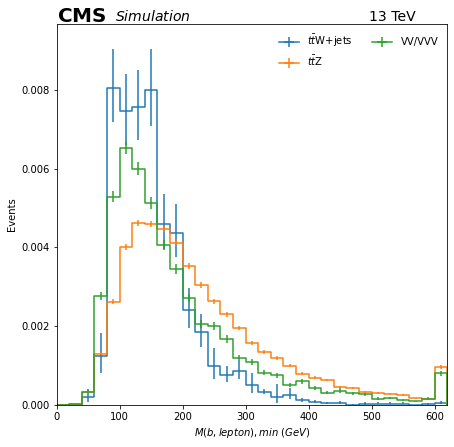

In [53]:
if True:
    try:
        fig, ax = plt.subplots(1,1,figsize=(7,7))
        notdata = re.compile('(?!pseudodata|wjets)')
        hist.plot1d(histogram[notdata],overlay="dataset", density=True, stack=False, overflow=bins[name]['overflow'], ax=ax) # make density plots because we don't care about x-sec differences
        for l in ['linear']:
            saveFig(fig, ax, None, plotDir, name+'_shape', scale=l, shape=True)
    except ValueError:
        print ("Can't make shape plot for a weird reason")

Indeed, the ttW shape has a much lower tail compared to ttZ and diboson!

## Final remarks

While we should use coffea to make meaningful histograms and cut flows in order to handle the large amount of data, most of the development of how to calculate variables should be done outside of coffea processors. They are really hard to debug, and usually it takes some time before the processor fails. It's much faster to just load a single root file and play with the methods and check whether the output is really what one expects.

Most of the code in the repository is a work-in-progress and will change over time. It's not expected to be bug free at this stage, please report any issues or questions.

I recommend that you look at the code and the functions that are imported, like the cutflow and object classes, and see what's happening there. Explaining every detail is a bit out of scope of this notebook.